# Analyse CIGALE Results for EMU sources

In [26]:
observatory = '/data/mfonseca/'
my_computer = '/home/polaris/Lab_Astro/data/'

directory = my_computer

## Import Libraries

In [27]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize


import numpy as np
import pandas as pd

import math

# Astropy
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo

# CuPY
# import cupy as cp

# Seaborn
import seaborn as sns

## Defined Log10 of the properties

In [28]:
catalog_path = '/home/polaris/Lab_Astro/data/cigale/emu_data/out_withAGN/EMU_0102-32_DESY6GOLD_VIKINGDR5_CATWISE_noMag_CIGALE.fits'
without_agn_path = '/home/polaris/Lab_Astro/data/cigale/emu_data/out_withoutAGN/results.fits'

catalog_table = Table.read(catalog_path)
catalog_pd = catalog_table.to_pandas()

without_agn = Table.read(without_agn_path)
without_agn_pd = without_agn.to_pandas()

catalog_pd= catalog_pd[catalog_pd['best.reduced_chi_square'] <= 5.0]
without_agn_pd=without_agn_pd[without_agn_pd['best.reduced_chi_square'] <= 5.0]

# Calculate log10 of parameters
catalog_pd['log_stellar_mass'] = np.log10(catalog_pd['bayes.stellar.m_star'])
catalog_pd['log_sfr'] = np.log10(catalog_pd['bayes.sfh.sfr'])
catalog_pd['log_sfr_permass'] = np.log10(catalog_pd['bayes.sfh.sfr'] / catalog_pd['bayes.stellar.m_star'])
catalog_pd['log_metallicity'] = np.log10(catalog_pd['bayes.stellar.metallicity'])
catalog_pd['log_age'] = np.log10(catalog_pd['bayes.sfh.age'])
catalog_pd['log_Av_BC'] = np.log10(catalog_pd['bayes.attenuation.Av_BC'])
catalog_pd['log_EMU_flux_int'] = np.log10(catalog_pd['EMU_flux_int'])

# Propagate errors for logs: Δ(log10 x) = Δx / (x * ln(10))
catalog_pd['log_stellar_mass_err'] = catalog_pd['bayes.stellar.m_star_err'] / (catalog_pd['bayes.stellar.m_star'] * np.log(10))
catalog_pd['log_sfr_err'] = catalog_pd['bayes.sfh.sfr_err'] / (catalog_pd['bayes.sfh.sfr'] * np.log(10))
catalog_pd['log_sfr_permass_err'] = np.sqrt(
    (catalog_pd['bayes.sfh.sfr_err'] / (catalog_pd['bayes.sfh.sfr'] * np.log(10)))**2 +
    (catalog_pd['bayes.stellar.m_star_err'] / (catalog_pd['bayes.stellar.m_star'] * np.log(10)))**2
)
catalog_pd['log_metallicity_err'] = catalog_pd['bayes.stellar.metallicity_err'] / (catalog_pd['bayes.stellar.metallicity'] * np.log(10))
catalog_pd['log_age_err'] = catalog_pd['bayes.sfh.age_err'] / (catalog_pd['bayes.sfh.age'] * np.log(10))
catalog_pd['log_Av_BC_err'] = catalog_pd['bayes.attenuation.Av_BC_err'] / (catalog_pd['bayes.attenuation.Av_BC'] * np.log(10))
catalog_pd['log_EMU_flux_int_err'] = catalog_pd['EMU_flux_int_err'] / (catalog_pd['EMU_flux_int'] * np.log(10))


## Average and error of the Properties

In [29]:
def simple_avg_and_error(values, errors):
    """
    Compute the unweighted average and its error from values and their individual 1σ uncertainties.

    Parameters:
    - values (pd.Series or np.ndarray): Measured values
    - errors (pd.Series or np.ndarray): 1σ uncertainties for each value (ignored in averaging)

    Returns:
    - avg (float): Simple mean of the values
    - avg_error (float): Standard error of the mean (std deviation divided by sqrt(N))
    """
    values = np.asarray(values)
    
    avg = np.median(values)
    avg_error = np.std(values, ddof=1) / np.sqrt(len(values))
    
    return avg, avg_error

In [30]:
avg_stellarmass, err_stellarmass = simple_avg_and_error(catalog_pd['bayes.stellar.m_star'], catalog_pd['bayes.stellar.m_star_err'])
print(r'Stellar Mass:', f'{np.log10(avg_stellarmass):.4f} ± {np.log10(err_stellarmass):.4f}')

avg_sfr, err_sfr = simple_avg_and_error(catalog_pd['bayes.sfh.sfr'], catalog_pd['bayes.sfh.sfr_err'])
print(r'Star Formation Rate:', f'{np.log10(avg_sfr):.4f} ± {np.log10(err_sfr):.4f}')

avg_metallicity, err_metallicity = simple_avg_and_error(catalog_pd['bayes.stellar.metallicity'], catalog_pd['bayes.stellar.metallicity_err'])
print(r'Metallicity:', f'{avg_metallicity:.4f} ± {err_metallicity:.4f}')

avg_age, err_age = simple_avg_and_error(catalog_pd['bayes.sfh.age'], catalog_pd['bayes.sfh.age_err'])
print(r'Age:', f'{np.log10(avg_age):.4f} ± {np.log10(err_age):.4f}')

avg_Av_BC, err_Av_BC = simple_avg_and_error(catalog_pd['bayes.attenuation.Av_BC'], catalog_pd['bayes.attenuation.Av_BC_err'])
print(r'Av_BC:', f'{avg_Av_BC:.4f} ± {err_Av_BC:.4f}')

avg_AGN, err_AGN = simple_avg_and_error(catalog_pd['bayes.agn.fracAGN'], catalog_pd['bayes.agn.fracAGN_err'])
print(r'AGN Fraction:', f'{avg_AGN:.4f} ± {err_AGN:.4f}')
                                                        

Stellar Mass: 11.0202 ± 9.7261
Star Formation Rate: 1.3882 ± 1.7934
Metallicity: 0.0205 ± 0.0001
Age: 3.5485 ± 1.4472
Av_BC: 0.5172 ± 0.0049
AGN Fraction: 0.1670 ± 0.0024


# Chi-Square Plot With and Without AGN module

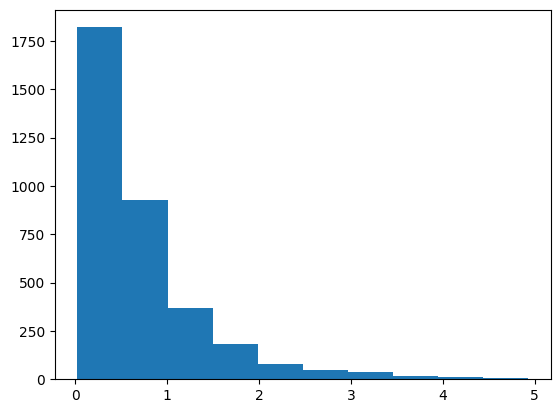

In [31]:
plt.hist(catalog_pd['best.reduced_chi_square'])
plt.show()

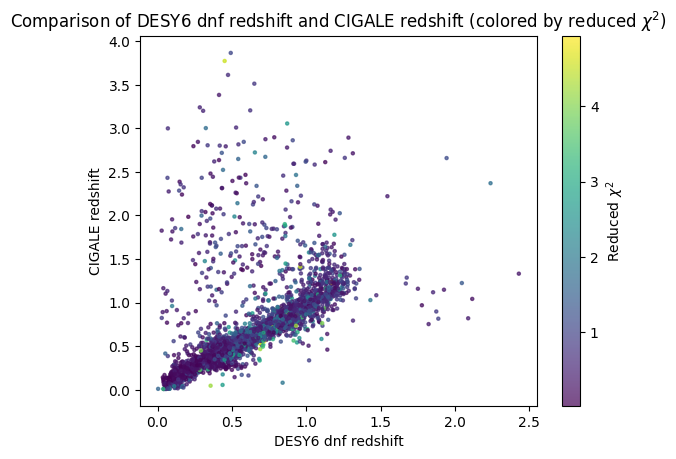

In [32]:
mask = catalog_pd['best.reduced_chi_square'] < 5

plt.scatter(
    catalog_pd.loc[mask, 'DESY6_dnf_z'],
    catalog_pd.loc[mask, 'bayes.universe.redshift'],
    c=catalog_pd.loc[mask, 'best.reduced_chi_square'],
    cmap='viridis',
    s=5,
    alpha=0.7
)
cbar = plt.colorbar(label=r'Reduced $\chi^2$')
plt.xlabel(r'DESY6 dnf redshift')
plt.ylabel(r'CIGALE redshift')
plt.title(r'Comparison of DESY6 dnf redshift and CIGALE redshift (colored by reduced $\chi^2$)')
plt.show()

In [33]:
# plt.scatter(catalog_pd['best.reduced_chi_square'], without_agn_pd['best.reduced_chi_square'], s=1, alpha=0.5)
# plt.xscale('log')
# plt.yscale('log')

# plt.xlabel(r'$\chi^2_{reduced}$ with AGN model')
# plt.ylabel(r'$\chi^2_{reduced}$ without AGN model')
# plt.title(r'Comparison of $\chi^2_{reduced}$ with and without AGN model')
# plt.show()

# Histogram of all results

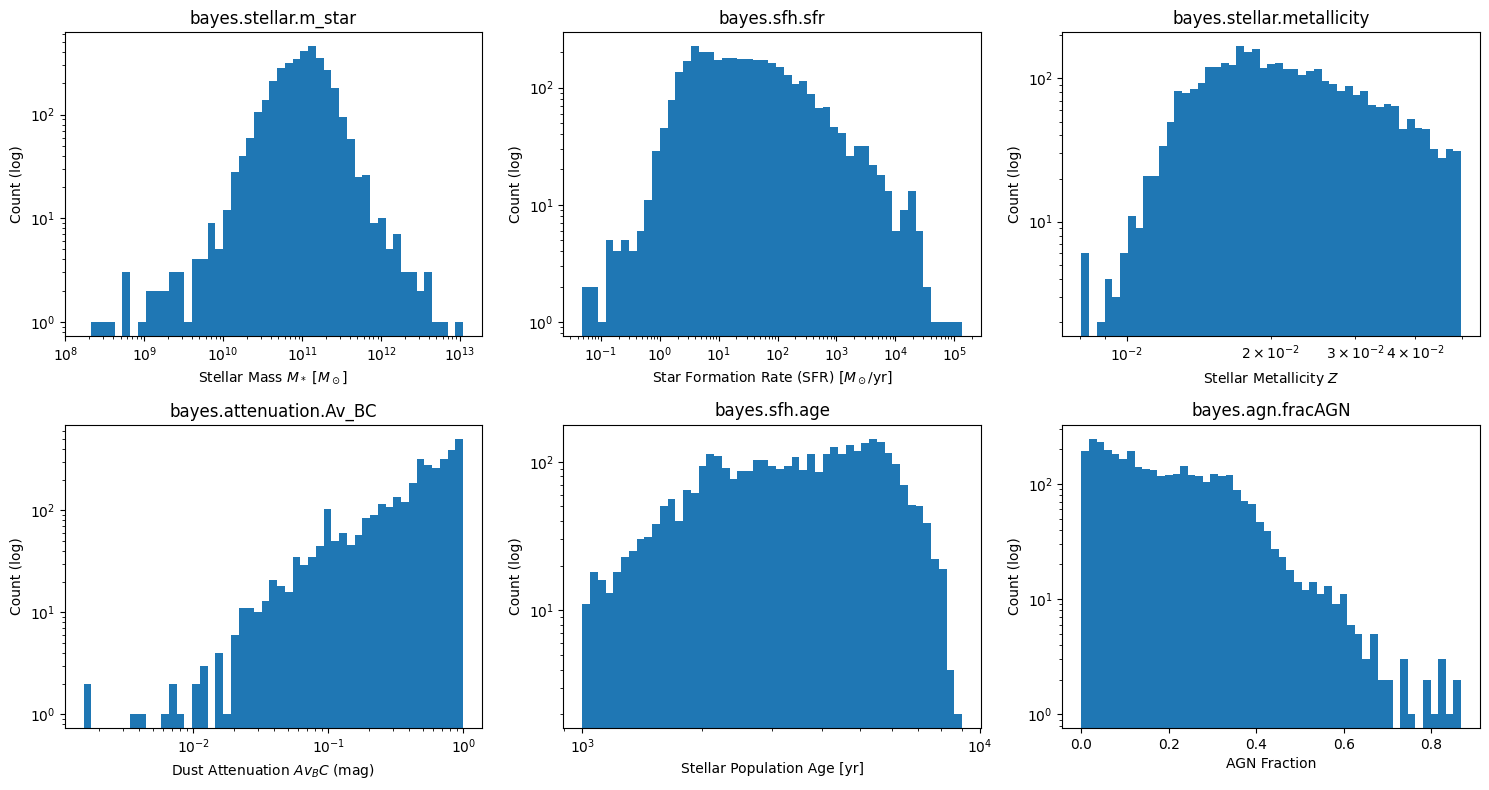

In [34]:
def plot_log_histograms_2rows_hist(df, columns, x_labels, figsize=(15, 8)):
    """
    Plot histograms (using .hist()) of specified DataFrame columns in 2 rows,
    with log-log scaling on both axes except for specific exceptions.

    Parameters:
    - df: pandas DataFrame
    - columns: list of column names to plot
    - x_labels: list of x-axis labels (same length as columns)
    - figsize: figure size (width, height)
    """
    n = len(columns)
    nrows = 2
    ncols = math.ceil(n / nrows)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)

    for i, col in enumerate(columns):
        row = i // ncols
        col_idx = i % ncols
        ax = axes[row, col_idx]

        data = df[col].dropna()

        # Identify whether to use log x-axis
        if 'bayes.agn.fracAGN' in col:
            # Linear x-axis bins
            bins = 50
            ax.hist(data, bins=bins)
            ax.set_yscale('log')  # Still use log y
        else:
            data = data[data > 0]  # log scale requires strictly positive values
            bins = np.logspace(np.log10(data.min()), np.log10(data.max()), 50)
            ax.hist(data, bins=bins)
            ax.set_xscale('log')
            ax.set_yscale('log')

        ax.set_title(col)
        ax.set_xlabel(x_labels[i])
        ax.set_ylabel('Count (log)')

    # Hide any unused subplots
    total_plots = nrows * ncols
    for j in range(n, total_plots):
        row = j // ncols
        col_idx = j % ncols
        axes[row, col_idx].axis('off')

    plt.tight_layout()
    plt.show()

x_labels = [
    r"Stellar Mass $M_*$ [$M_\odot$]",
    r"Star Formation Rate (SFR) [$M_\odot$/yr]",
    r"Stellar Metallicity $Z$",
    r"Dust Attenuation $Av_BC$ (mag)",
    r"Stellar Population Age [yr]",
    r"AGN Fraction"
]

# Example usage:
plot_log_histograms_2rows_hist(catalog_pd , ['bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.stellar.metallicity','bayes.attenuation.Av_BC','bayes.sfh.age' ,'bayes.agn.fracAGN'], x_labels)


# Interesting plots

## AGN fraction vs Stellar Mass , colored by redshift

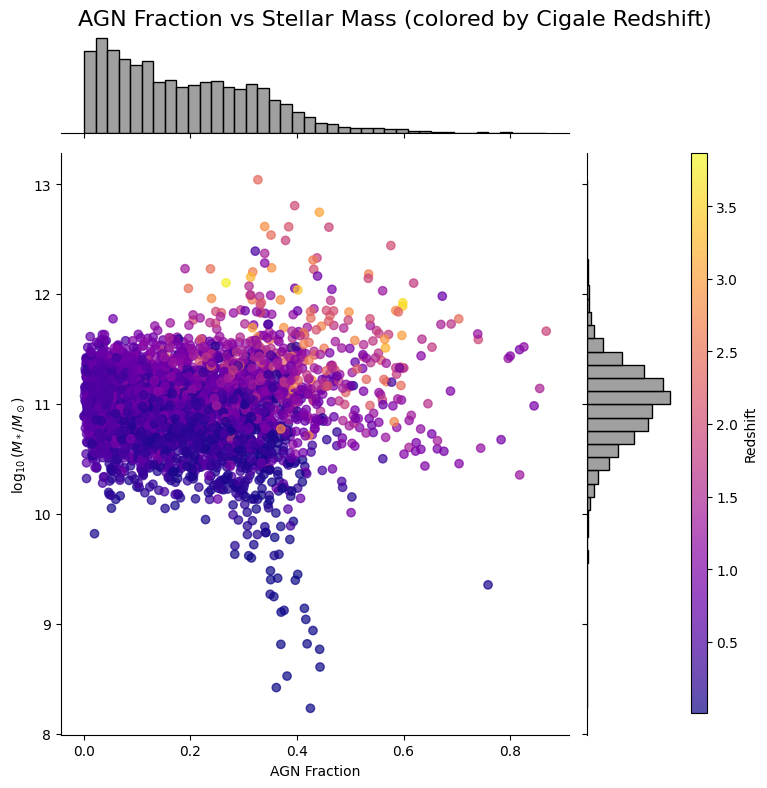

In [35]:
# Compute log stellar mass
catalog_pd['log_stellar_mass'] = np.log10(catalog_pd['bayes.stellar.m_star'])

# Create the JointGrid
g = sns.JointGrid(
    data=catalog_pd,
    x='bayes.agn.fracAGN',
    y='log_stellar_mass',
    height=8
)

# Main scatterplot with color by redshift
points = g.ax_joint.scatter(
    catalog_pd['bayes.agn.fracAGN'],
    catalog_pd['log_stellar_mass'],
    c=catalog_pd['bayes.universe.redshift'],
    cmap='plasma',
    alpha=0.7
)

# Add marginal histograms
sns.histplot(
    data=catalog_pd,
    x='bayes.agn.fracAGN',
    bins=40,
    ax=g.ax_marg_x,
    color='grey',
    edgecolor='black'
)
sns.histplot(
    data=catalog_pd,
    y='log_stellar_mass',
    bins=40,
    ax=g.ax_marg_y,
    color='grey',
    edgecolor='black'
)

# Set axis labels and title
g.set_axis_labels('AGN Fraction', r'$\log_{10}(M_*/M_\odot)$')
g.fig.suptitle('AGN Fraction vs Stellar Mass (colored by Cigale Redshift)', fontsize=16)
g.fig.subplots_adjust(top=0.95, right=0.85)  # Shrink plot area to make room for colorbar

# Add external colorbar
cbar_ax = g.fig.add_axes([0.87, 0.1, 0.02, 0.7])  # [left, bottom, width, height]
g.fig.colorbar(points, cax=cbar_ax, label='Redshift')

plt.show()


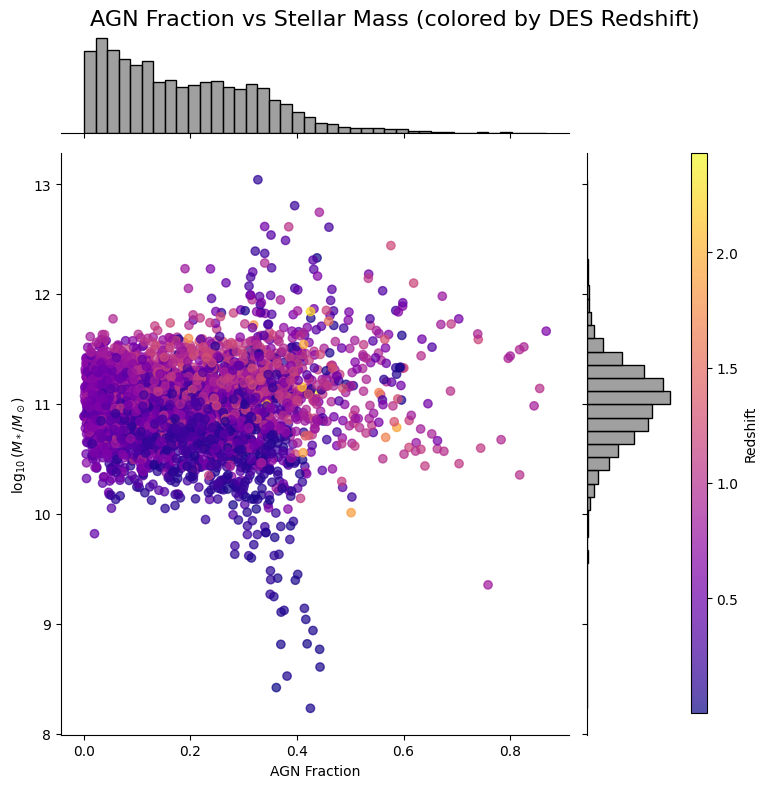

In [36]:
# Compute log stellar mass
catalog_pd['log_stellar_mass'] = np.log10(catalog_pd['bayes.stellar.m_star'])

# Create the JointGrid
g = sns.JointGrid(
    data=catalog_pd,
    x='bayes.agn.fracAGN',
    y='log_stellar_mass',
    height=8
)

# Main scatterplot with color by redshift
points = g.ax_joint.scatter(
    catalog_pd['bayes.agn.fracAGN'],
    catalog_pd['log_stellar_mass'],
    c=catalog_pd['DESY6_dnf_z'],
    cmap='plasma',
    alpha=0.7
)

# Add marginal histograms
sns.histplot(
    data=catalog_pd,
    x='bayes.agn.fracAGN',
    bins=40,
    ax=g.ax_marg_x,
    color='grey',
    edgecolor='black'
)
sns.histplot(
    data=catalog_pd,
    y='log_stellar_mass',
    bins=40,
    ax=g.ax_marg_y,
    color='grey',
    edgecolor='black'
)

# Set axis labels and title
g.set_axis_labels('AGN Fraction', r'$\log_{10}(M_*/M_\odot)$')
g.fig.suptitle('AGN Fraction vs Stellar Mass (colored by DES Redshift)', fontsize=16)
g.fig.subplots_adjust(top=0.95, right=0.85)  # Shrink plot area to make room for colorbar

# Add external colorbar
cbar_ax = g.fig.add_axes([0.87, 0.1, 0.02, 0.7])  # [left, bottom, width, height]
g.fig.colorbar(points, cax=cbar_ax, label='Redshift')

plt.show()

## SFR vs Stellar Mass , colored by redshift

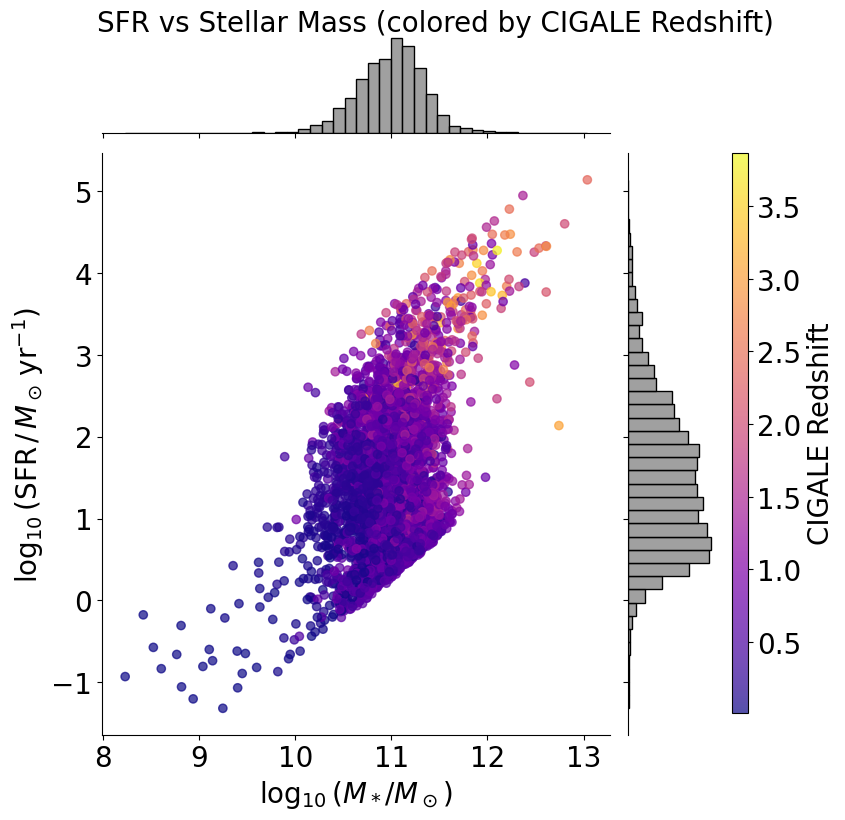

In [37]:
# Create the JointGrid
g = sns.JointGrid(
    data=catalog_pd,
    x='log_stellar_mass',
    y='log_sfr',
    height=8
)

# Main scatterplot with color by redshift
points = g.ax_joint.scatter(
    catalog_pd['log_stellar_mass'],
    catalog_pd['log_sfr'],
    c=catalog_pd['bayes.universe.redshift'],
    cmap='plasma',
    alpha=0.7
)

# Add marginal histograms
sns.histplot(
    data=catalog_pd,
    x='log_stellar_mass',
    bins=40,
    ax=g.ax_marg_x,
    color='grey',
    edgecolor='black'
)
sns.histplot(
    data=catalog_pd,
    y='log_sfr',
    bins=40,
    ax=g.ax_marg_y,
    color='grey',
    edgecolor='black'
)

# Set axis labels and title with larger font
g.set_axis_labels(
    r'$\log_{10}(M_*/M_\odot)$',
    r'$\log_{10}({\rm SFR}\,/\,M_\odot\,{\rm yr}^{-1})$',
    fontsize=20
)
g.ax_joint.tick_params(axis='both', labelsize=20)
g.ax_marg_x.tick_params(labelsize=20)
g.ax_marg_y.tick_params(labelsize=20)

# Title
g.fig.suptitle('SFR vs Stellar Mass (colored by CIGALE Redshift)', fontsize=20)
g.fig.subplots_adjust(top=0.95, right=0.85)  # Shrink plot area to make room for colorbar

# Add external colorbar with larger label and ticks
cbar_ax = g.fig.add_axes([0.87, 0.1, 0.02, 0.7])
cbar = g.fig.colorbar(points, cax=cbar_ax)
cbar.set_label('CIGALE Redshift', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.show()

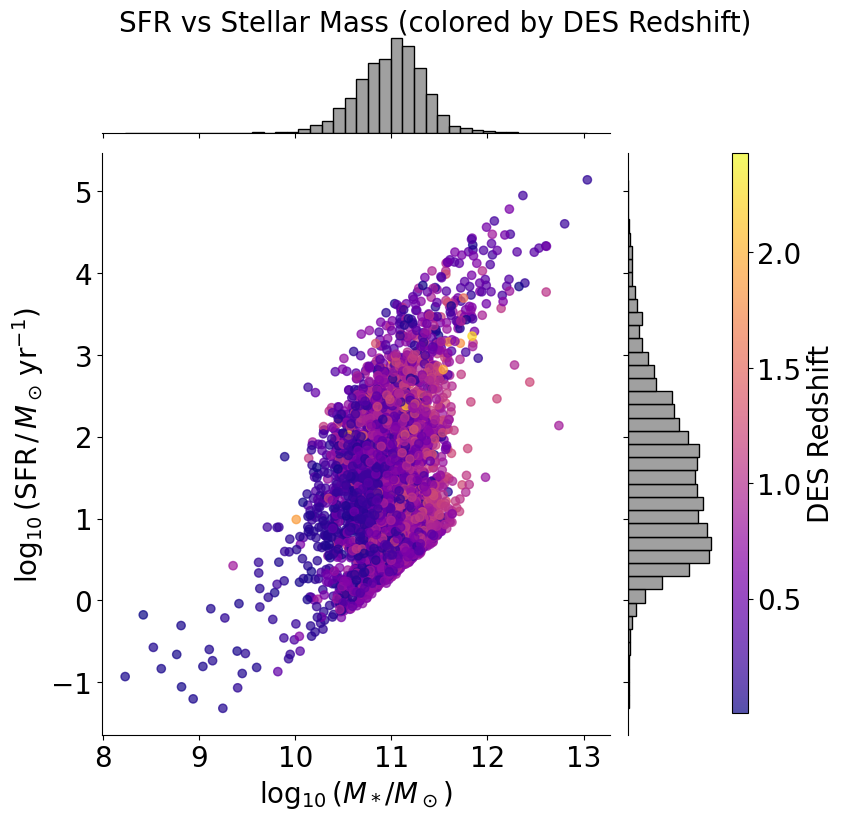

In [38]:
# Create the JointGrid
g = sns.JointGrid(
    data=catalog_pd,
    x='log_stellar_mass',
    y='log_sfr',
    height=8
)

# Main scatterplot with color by redshift
points = g.ax_joint.scatter(
    catalog_pd['log_stellar_mass'],
    catalog_pd['log_sfr'],
    c=catalog_pd['DESY6_dnf_z'],
    cmap='plasma',
    alpha=0.7
)

# Add marginal histograms
sns.histplot(
    data=catalog_pd,
    x='log_stellar_mass',
    bins=40,
    ax=g.ax_marg_x,
    color='grey',
    edgecolor='black'
)
sns.histplot(
    data=catalog_pd,
    y='log_sfr',
    bins=40,
    ax=g.ax_marg_y,
    color='grey',
    edgecolor='black'
)

# Set axis labels and title with larger font
g.set_axis_labels(
    r'$\log_{10}(M_*/M_\odot)$',
    r'$\log_{10}({\rm SFR}\,/\,M_\odot\,{\rm yr}^{-1})$',
    fontsize=20
)
g.ax_joint.tick_params(axis='both', labelsize=20)
g.ax_marg_x.tick_params(labelsize=20)
g.ax_marg_y.tick_params(labelsize=20)

# Title
g.fig.suptitle('SFR vs Stellar Mass (colored by DES Redshift)', fontsize=20)
g.fig.subplots_adjust(top=0.95, right=0.85)  # Shrink plot area to make room for colorbar

# Add external colorbar with larger label and ticks
cbar_ax = g.fig.add_axes([0.87, 0.1, 0.02, 0.7])
cbar = g.fig.colorbar(points, cax=cbar_ax)
cbar.set_label('DES Redshift', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.show()

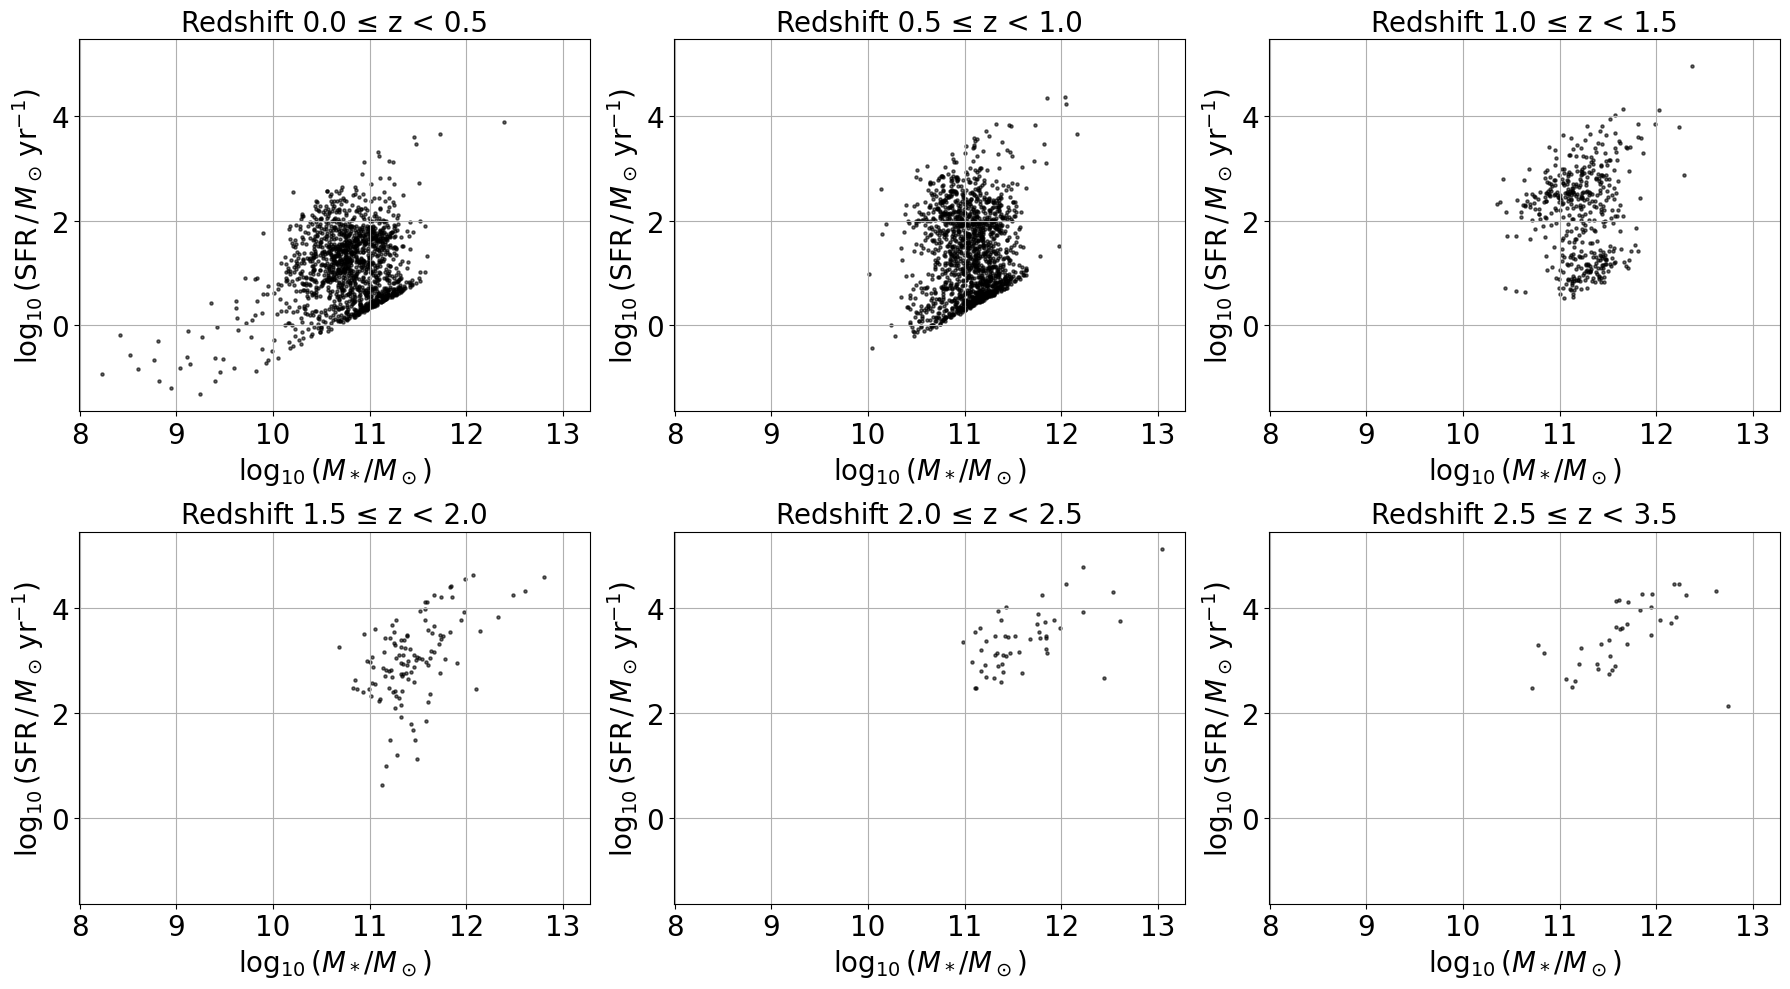

In [39]:
bins = [(0.0, 0.5), (0.5, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, 2.5), (2.5, 3.5)]

# Determine global axis limits
x_min, x_max = catalog_pd['log_stellar_mass'].min(), catalog_pd['log_stellar_mass'].max()
y_min, y_max = catalog_pd['log_sfr'].min(), catalog_pd['log_sfr'].max()

# Optional: Add padding
x_pad = 0.05 * (x_max - x_min)
y_pad = 0.05 * (y_max - y_min)
xlim = (x_min - x_pad, x_max + x_pad)
ylim = (y_min - y_pad, y_max + y_pad)

# Create a 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Loop over redshift bins and create scatter plots
for i, (zmin, zmax) in enumerate(bins):
    ax = axes[i]
    zmask = (catalog_pd['bayes.universe.redshift'] >= zmin) & (catalog_pd['bayes.universe.redshift'] < zmax)
    subset = catalog_pd[zmask]

    ax.scatter(
        subset['log_stellar_mass'],
        subset['log_sfr'],
        color='black',
        s=5,
        alpha=0.6
    )
    
    ax.set_title(f'Redshift {zmin} ≤ z < {zmax}', fontsize=20)
    ax.set_xlabel(r'$\log_{10}(M_*/M_\odot)$', fontsize=20)
    ax.set_ylabel(r'$\log_{10}({\rm SFR}\,/\,M_\odot\,{\rm yr}^{-1})$', fontsize=20)
    ax.tick_params(labelsize=20)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(True)

# Hide the 6th (unused) subplot
#axes[-1].axis('off')

plt.tight_layout()
plt.show()

/tmp/ipykernel_23748/601375363.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar


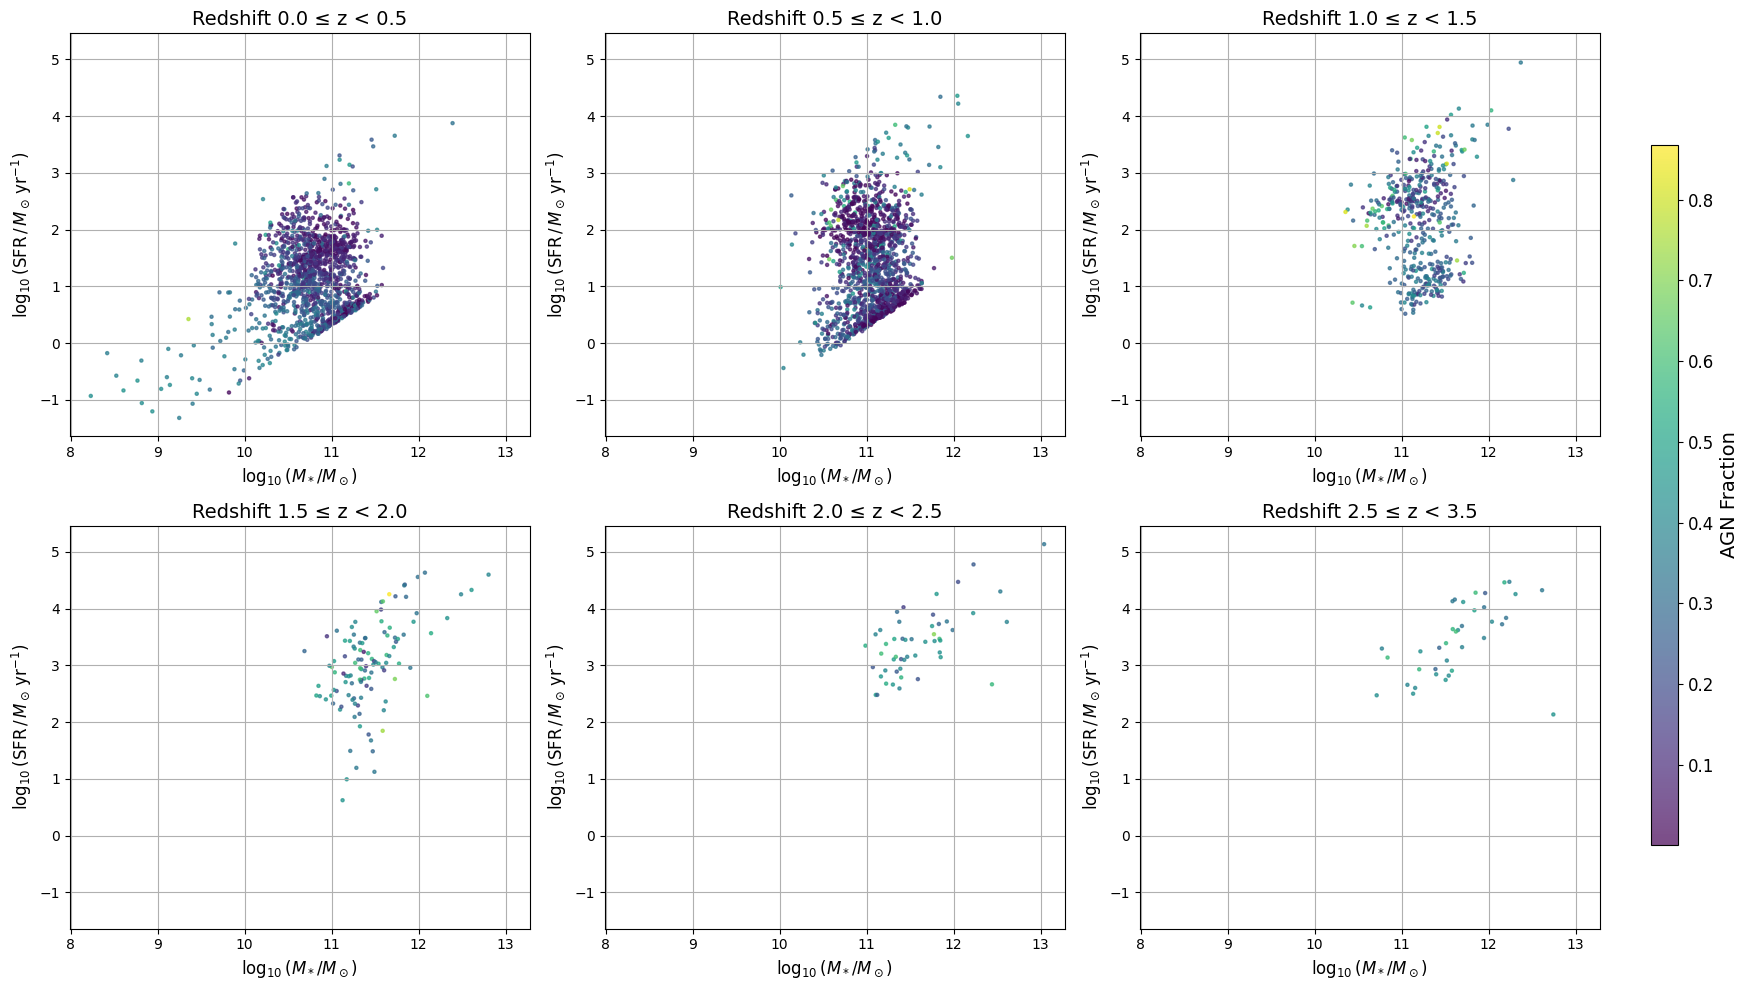

In [40]:
# Define redshift bins
bins = [(0.0, 0.5), (0.5, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, 2.5), (2.5, 3.5)]

# Determine global axis limits
x_min, x_max = catalog_pd['log_stellar_mass'].min(), catalog_pd['log_stellar_mass'].max()
y_min, y_max = catalog_pd['log_sfr'].min(), catalog_pd['log_sfr'].max()
x_pad = 0.05 * (x_max - x_min)
y_pad = 0.05 * (y_max - y_min)
xlim = (x_min - x_pad, x_max + x_pad)
ylim = (y_min - y_pad, y_max + y_pad)

# Set up color normalization and colormap
norm = plt.Normalize(vmin=catalog_pd['bayes.agn.fracAGN'].min(), 
                     vmax=catalog_pd['bayes.agn.fracAGN'].max())
cmap = plt.cm.viridis

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
scs = []  # to collect scatter plots for colorbar

# Loop through redshift bins
for i, (zmin, zmax) in enumerate(bins):
    ax = axes[i]
    zmask = (catalog_pd['bayes.universe.redshift'] >= zmin) & (catalog_pd['bayes.universe.redshift'] < zmax)
    subset = catalog_pd[zmask]

    sc = ax.scatter(
        subset['log_stellar_mass'],
        subset['log_sfr'],
        c=subset['bayes.agn.fracAGN'],
        cmap=cmap,
        norm=norm,
        s=5,
        alpha=0.7
    )
    scs.append(sc)

    ax.set_title(f'Redshift {zmin} ≤ z < {zmax}', fontsize=14)
    ax.set_xlabel(r'$\log_{10}(M_*/M_\odot)$', fontsize=12)
    ax.set_ylabel(r'$\log_{10}({\rm SFR}\,/\,M_\odot\,{\rm yr}^{-1})$', fontsize=12)
    ax.tick_params(labelsize=10)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(True)

# Hide the 6th (unused) subplot
# axes[-1].axis('off')

# Shared colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
cbar = fig.colorbar(scs[0], cax=cbar_ax)
cbar.set_label('AGN Fraction', fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar
plt.show()


## Grid of Plots

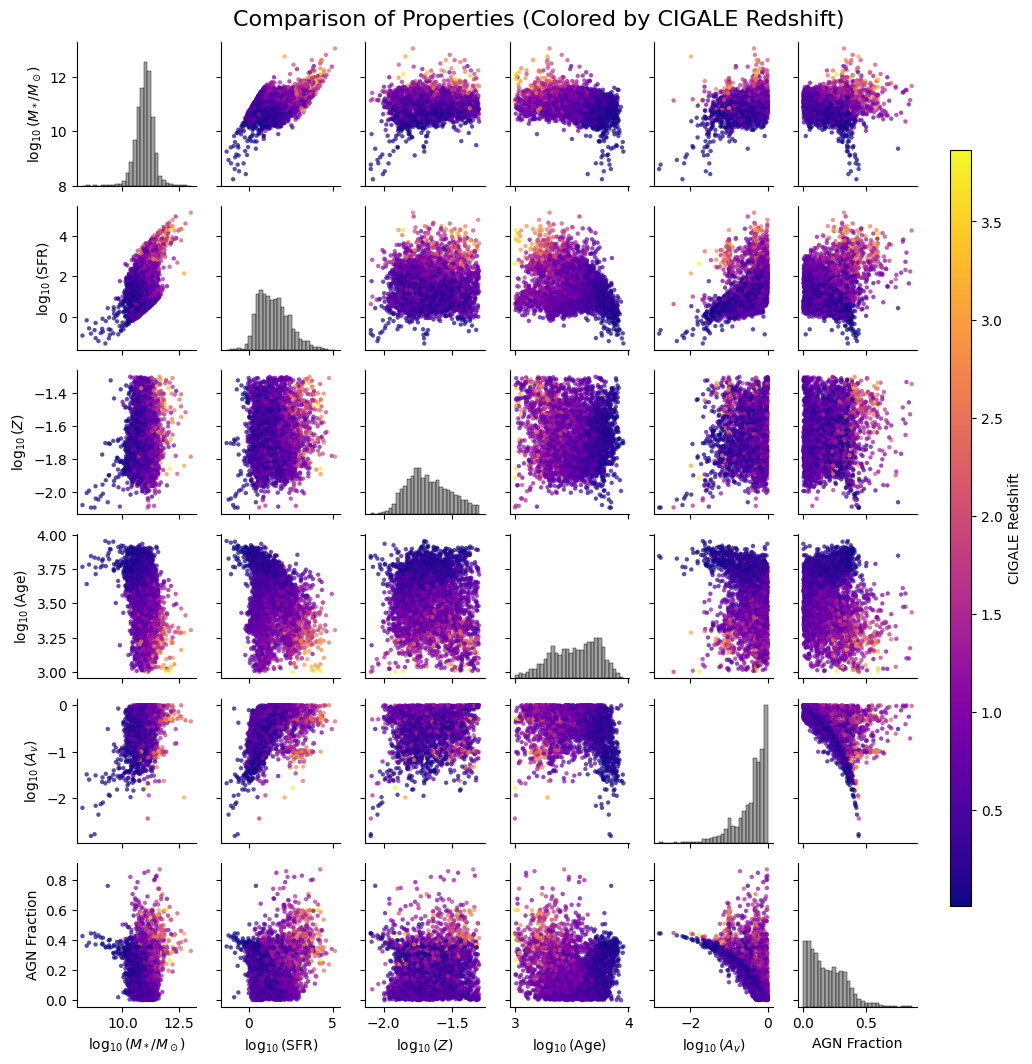

In [41]:
properties = ['log_stellar_mass', 'log_sfr', 'log_metallicity', 'log_age', 'log_Av_BC', 'bayes.agn.fracAGN']

labels = {
    'log_stellar_mass': r'$\log_{10}(M_*/M_\odot)$',
    'log_sfr': r'$\log_{10}(\mathrm{SFR})$',
    'log_metallicity': r'$\log_{10}(Z)$',
    'log_age': r'$\log_{10}(\mathrm{Age})$',
    'log_Av_BC': r'$\log_{10}(A_v)$',
    'bayes.agn.fracAGN': r'AGN Fraction'
}

plot_df = catalog_pd[properties]

# Create PairGrid
g = sns.PairGrid(
    data=plot_df,
    vars=properties,
    height=1.8,
    aspect=1
)

# Diagonal: histograms
g.map_diag(sns.histplot, color='grey', bins=30)

# Off-diagonal: scatter plots with continuous redshift coloring
g.map_offdiag(
    sns.scatterplot,
    hue=catalog_pd['bayes.universe.redshift'],
    palette='plasma',
    alpha=0.7,
    s=10,
    linewidth=0
)

# Create colorbar
norm = Normalize(
    vmin=catalog_pd['bayes.universe.redshift'].min(),
    vmax=catalog_pd['bayes.universe.redshift'].max()
)
sm = ScalarMappable(norm=norm, cmap='plasma')
sm.set_array([])

# Adjust subplot layout to make space for colorbar
plt.subplots_adjust(right=0.85)  # Increase right margin

# Add colorbar to a specific axis (far right)
cbar_ax = g.fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = g.fig.colorbar(
    sm,
    cax=cbar_ax,
    label='CIGALE Redshift'
)

# Set custom axis labels
for ax, var in zip(g.axes[-1, :], properties):
    ax.set_xlabel(labels[var], fontsize=10)
for ax, var in zip(g.axes[:, 0], properties):
    ax.set_ylabel(labels[var], fontsize=10)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Comparison of Properties (Colored by CIGALE Redshift)', fontsize=16)

plt.show()

# AGN fraction vs Redshift

/tmp/ipykernel_23748/3181773311.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


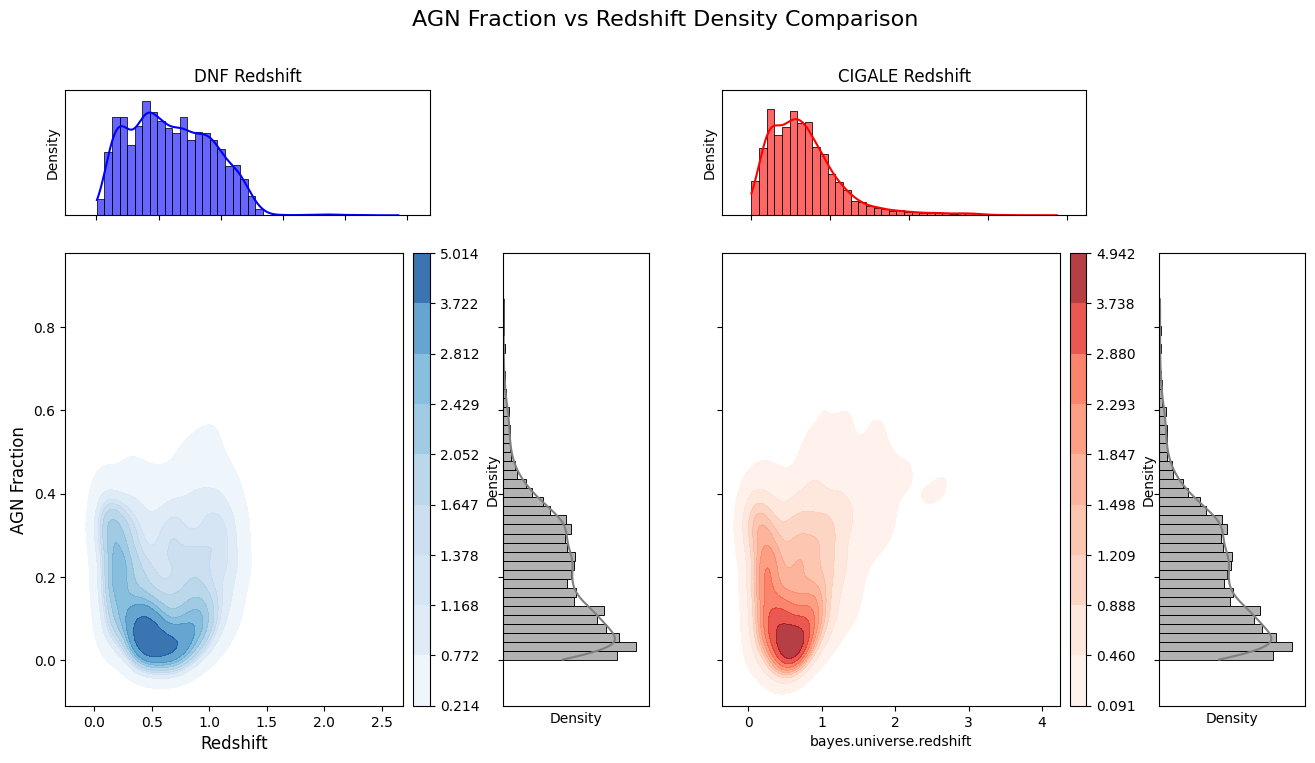

In [42]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Assuming catalog_pd is already loaded and contains your data

# --- Determine Max Density for Shared Scale ---
# Calculate densities for all histograms to find the global maximum
dnf_z_hist, _ = np.histogram(catalog_pd['DESY6_dnf_z'].dropna(), bins=40, density=True)
cigale_z_hist, _ = np.histogram(catalog_pd['bayes.universe.redshift'].dropna(), bins=40, density=True)
agn_frac_hist, _ = np.histogram(catalog_pd['bayes.agn.fracAGN'].dropna(), bins=40, density=True)

max_density_z = max(dnf_z_hist.max(), cigale_z_hist.max())
max_density_agn = agn_frac_hist.max()

# Create a figure with a grid that clearly defines two main plotting areas
fig = plt.figure(figsize=(16, 8)) # Wider figure for more space
grid = plt.GridSpec(4, 6, hspace=0.3, wspace=0.5) # Increased wspace for more separation

# --- Left Column Plot Set (DNF Redshift) ---
ax_main_dnf = fig.add_subplot(grid[1:4, 0:2])
ax_top_dnf = fig.add_subplot(grid[0, 0:2], sharex=ax_main_dnf)
ax_right_dnf = fig.add_subplot(grid[1:4, 2], sharey=ax_main_dnf)

# KDE Plot for DNF Redshift
kde_dnf = sns.kdeplot(
    x=catalog_pd['DESY6_dnf_z'],
    y=catalog_pd['bayes.agn.fracAGN'],
    fill=True,
    cmap='Blues',
    alpha=0.8,
    ax=ax_main_dnf
)
# Add a compact colorbar for DNF KDE
divider_dnf = make_axes_locatable(ax_main_dnf)
cax_dnf = divider_dnf.append_axes("right", size="5%", pad=0.1)
plt.colorbar(kde_dnf.collections[0], cax=cax_dnf, label='Density')

# Top Histogram (DNF Redshift)
sns.histplot(
    catalog_pd['DESY6_dnf_z'],
    bins=40,
    color='blue',
    alpha=0.6,
    kde=True,
    ax=ax_top_dnf,
    stat='density'
)
ax_top_dnf.set_ylabel('Density')
ax_top_dnf.set_yticks([])
ax_top_dnf.set_xlabel('')
ax_top_dnf.set_title('DNF Redshift', fontsize=12)
ax_top_dnf.set_ylim(0, max_density_z * 1.1) # Apply shared Y-limit for density

# Right Histogram (AGN fraction for DNF Redshift)
sns.histplot(
    y=catalog_pd['bayes.agn.fracAGN'],
    bins=40,
    color='grey',
    alpha=0.6,
    kde=True,
    ax=ax_right_dnf,
    stat='density'
)
ax_right_dnf.set_xlabel('Density')
ax_right_dnf.set_xticks([])
ax_right_dnf.set_ylabel('')
ax_right_dnf.set_xlim(0, max_density_agn * 1.1) # Apply shared X-limit for density


# --- Right Column Plot Set (CIGALE Redshift) ---
ax_main_cigale = fig.add_subplot(grid[1:4, 3:5], sharey=ax_main_dnf)
ax_top_cigale = fig.add_subplot(grid[0, 3:5], sharex=ax_main_cigale)
ax_right_cigale = fig.add_subplot(grid[1:4, 5], sharey=ax_main_dnf) # Share Y with DNF main for consistency

# KDE Plot for CIGALE Redshift
kde_cigale = sns.kdeplot(
    x=catalog_pd['bayes.universe.redshift'],
    y=catalog_pd['bayes.agn.fracAGN'],
    fill=True,
    cmap='Reds',
    alpha=0.8,
    ax=ax_main_cigale
)
# Add a compact colorbar for CIGALE KDE
divider_cigale = make_axes_locatable(ax_main_cigale)
cax_cigale = divider_cigale.append_axes("right", size="5%", pad=0.1)
plt.colorbar(kde_cigale.collections[0], cax=cax_cigale, label='Density')


# Top Histogram (CIGALE Redshift)
sns.histplot(
    catalog_pd['bayes.universe.redshift'],
    bins=40,
    color='red',
    alpha=0.6,
    kde=True,
    ax=ax_top_cigale,
    stat='density'
)
ax_top_cigale.set_ylabel('Density')
ax_top_cigale.set_yticks([])
ax_top_cigale.set_xlabel('')
ax_top_cigale.set_title('CIGALE Redshift', fontsize=12)
ax_top_cigale.set_ylim(0, max_density_z * 1.1) # Apply shared Y-limit for density


# Right Histogram (AGN fraction for CIGALE Redshift)
sns.histplot(
    y=catalog_pd['bayes.agn.fracAGN'],
    bins=40,
    color='grey',
    alpha=0.6,
    kde=True,
    ax=ax_right_cigale,
    stat='density'
)
ax_right_cigale.set_xlabel('Density')
ax_right_cigale.set_xticks([])
ax_right_cigale.set_ylabel('')
ax_right_cigale.set_xlim(0, max_density_agn * 1.1) # Apply shared X-limit for density


# --- General Customizations ---
# Set common labels for the main plots
ax_main_dnf.set_xlabel('Redshift', fontsize=12)
ax_main_dnf.set_ylabel('AGN Fraction', fontsize=12)

# Hide y-labels and ticks for the right main plot to avoid redundancy
ax_main_cigale.set_ylabel('')
plt.setp(ax_main_cigale.get_yticklabels(), visible=False)

# Hide x-labels/ticks for top marginals, and y-labels/ticks for right marginals
plt.setp(ax_top_dnf.get_xticklabels(), visible=False)
plt.setp(ax_right_dnf.get_yticklabels(), visible=False)
plt.setp(ax_top_cigale.get_xticklabels(), visible=False)
plt.setp(ax_right_cigale.get_yticklabels(), visible=False)

# Set the overall title
fig.suptitle('AGN Fraction vs Redshift Density Comparison', fontsize=16, y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

/tmp/ipykernel_23748/4114143028.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


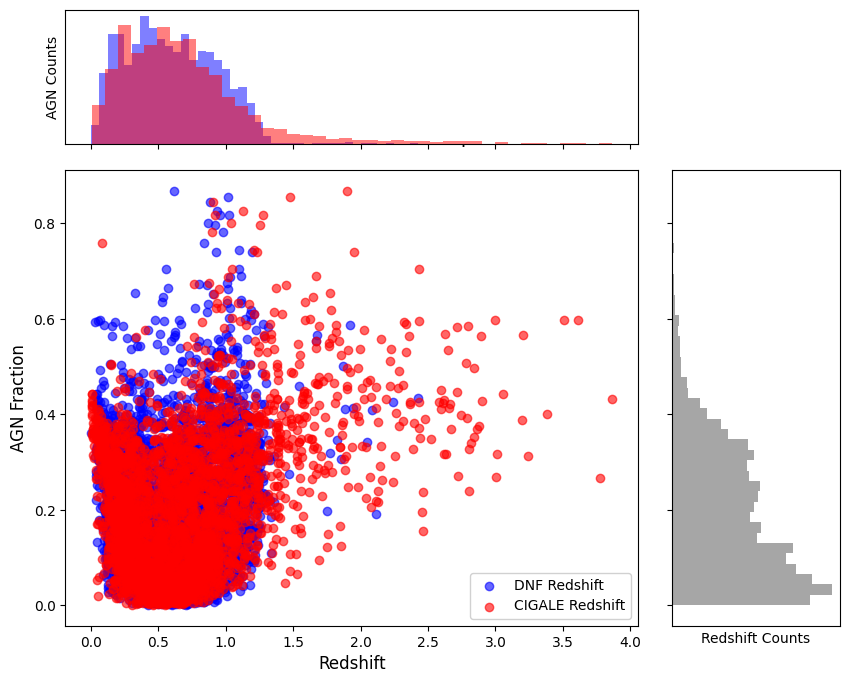

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create figure with main plot and marginal histograms
fig = plt.figure(figsize=(10, 8))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)

# Main scatter plot
main_ax = fig.add_subplot(grid[1:4, 0:3])
# Top histogram (redshifts)
top_ax = fig.add_subplot(grid[0, 0:3], sharex=main_ax)
# Right histogram (AGN fraction)
right_ax = fig.add_subplot(grid[1:4, 3], sharey=main_ax)

# Plot both redshift types in main plot
scatter1 = main_ax.scatter(
    catalog_pd['DESY6_dnf_z'],
    catalog_pd['bayes.agn.fracAGN'],
    alpha=0.6,
    color='blue',
    label='DNF Redshift'
)

scatter2 = main_ax.scatter(
    catalog_pd['bayes.universe.redshift'],
    catalog_pd['bayes.agn.fracAGN'],
    alpha=0.6,
    color='red',
    label='CIGALE Redshift'
)

# Plot histograms
# Top histogram (redshift distributions)
top_ax.hist(
    catalog_pd['DESY6_dnf_z'],
    bins=40,
    color='blue',
    alpha=0.5,
    density=True
)
top_ax.hist(
    catalog_pd['bayes.universe.redshift'],
    bins=40,
    color='red',
    alpha=0.5,
    density=True
)
top_ax.set_ylabel('AGN Counts')
top_ax.set_yticks([])  # Hide y ticks

# Right histogram (AGN fraction distribution)
right_ax.hist(
    catalog_pd['bayes.agn.fracAGN'],
    bins=40,
    color='grey',
    alpha=0.7,
    orientation='horizontal',
    density=True
)
right_ax.set_xlabel('Redshift Counts')
right_ax.set_xticks([])  # Hide x ticks

# Customize main plot
main_ax.set_xlabel('Redshift', fontsize=12)
main_ax.set_ylabel('AGN Fraction', fontsize=12)
main_ax.set_title('AGN Fraction vs Redshift Comparison', fontsize=14, pad=20)

# Add legend inside main plot
main_ax.legend(
    loc='lower right',
    frameon=True,
    framealpha=0.9,
    fontsize=10
)

# Clean up appearance
plt.setp(top_ax.get_xticklabels(), visible=False)  # Hide x ticks on top hist
plt.setp(right_ax.get_yticklabels(), visible=False)  # Hide y ticks on right hist

plt.tight_layout()
plt.show()


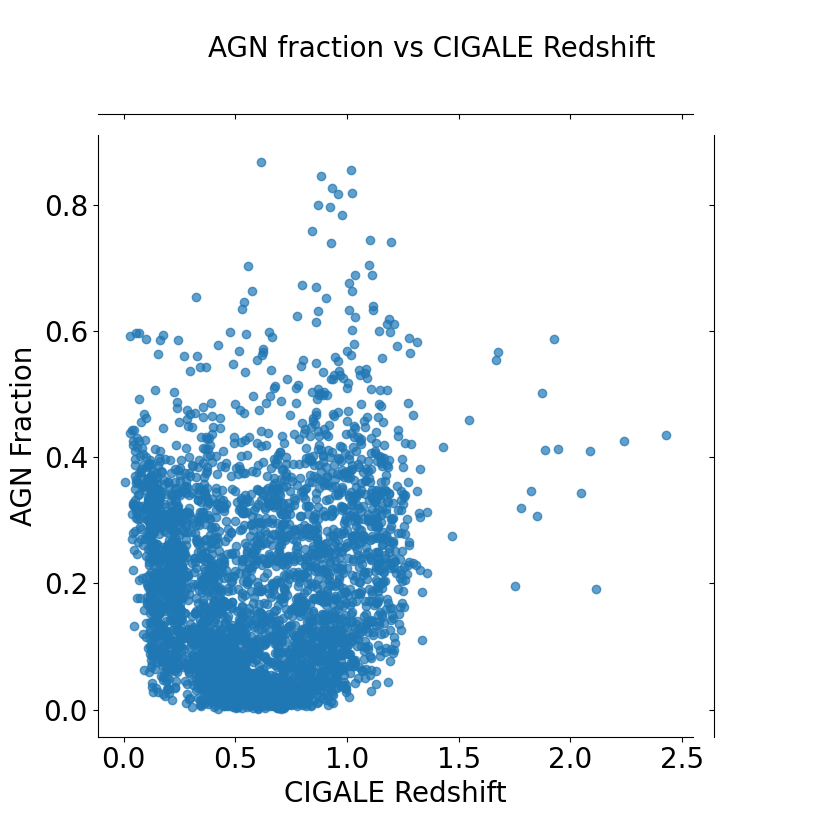

In [44]:
# Create the JointGrid
g = sns.JointGrid(
    data=catalog_pd,
    x='bayes.universe.redshift',
    y='bayes.agn.fracAGN',
    height=8
)

# Main scatterplot with color by redshift
points = g.ax_joint.scatter(
    catalog_pd['DESY6_dnf_z'],
    catalog_pd['bayes.agn.fracAGN'],
    alpha=0.7
)

# Set axis labels and title with larger font
g.set_axis_labels(
    r'CIGALE Redshift',
    r'AGN Fraction',
    fontsize=20
)
g.ax_joint.tick_params(axis='both', labelsize=20)
g.ax_marg_x.tick_params(labelsize=20)
g.ax_marg_y.tick_params(labelsize=20)

# Title
g.fig.suptitle('AGN fraction vs CIGALE Redshift', fontsize=20, y=.95)

plt.show()

# Comparison between Star Formation Rate and Radio Emission

## Luminosity from EMU vs Luminosity from CIGALE

In [45]:
# CONVERT EMU 943 MHz FLUX to 1.4 GHz LUMINOSITY

redshift = catalog_pd['bayes.universe.redshift'].values
flux_943MHz = catalog_pd['EMU_flux_int'].values * u.mJy  # flux is in milliJansky according to the catalog

alpha = -0.7  

# Luminosity distance, Mpc to meters
luminosity_distance = cosmo.luminosity_distance(redshift).to(u.m)

# Convert flux from mJy to W m^-2 Hz^-1
flux_943MHz_SI = flux_943MHz.to(u.W * u.m**-2 * u.Hz**-1) 

# 1.4 GHz luminosity using formula from 
# 'Probing the timescale of the 1.4 GHz radio emissions as a star formation tracer' R. C. Arango-Toro, et al. 2023
# L_1.4 = 4πD_L^2 × (1.4/0.943)^α × F_0.943 / (1 + z)^(1 + α)
luminosity_1_4GHz = (
    4 * np.pi * luminosity_distance**2 * 
    (1.4 / 0.943)**alpha *  # (1.4 / 0.943)^α
    flux_943MHz_SI / 
    (1 + redshift)**(1+alpha)  # (1 + z)^(1 + α)
)

# 943MHz luminosity
luminosity_943MHz = (
    4 * np.pi * luminosity_distance**2 * 
    flux_943MHz_SI / 
    (1 + redshift)**(1+alpha)  # (1 + z)^(1 + α)
)

log_luminosity_943MHz = pd.Series(np.log10(luminosity_943MHz.value))

# The result from the formula is in W Hz^-1
# Convert to log10 of (erg s^-1 Hz^-1)
log_luminosity_1_4GHz_obs_watt = pd.Series(np.log10(luminosity_1_4GHz.value))
log_luminosity_1_4GHz_obs = pd.Series(np.log10(luminosity_1_4GHz.to(u.erg / (u.s * u.Hz)).value))

###########################################################################################################

# CONVERT CIGALE SFR TO 1.4 GHz LUMINOSITY
# Asssuming that the SFR of CIGALE is the same at 1.4 GHz
# 'CALIBRATING EXTINCTION-FREE STAR FORMATION RATE DIAGNOSTICS WITH 33 GHz FREE–FREE EMISSION IN NGC 6946', E. J. Murphy 2011
# This formula return the luminosity in erg s^-1 Hz^-1
log_luminosity_1_4GHz_theor_watt = np.log10((catalog_pd['bayes.sfh.sfr'] / 6.35e-29)) -7
log_luminosity_1_4GHz_theor = np.log10((catalog_pd['bayes.sfh.sfr'] / 6.35e-29))


## Luminosity from EMU vs CIGALE Redshift

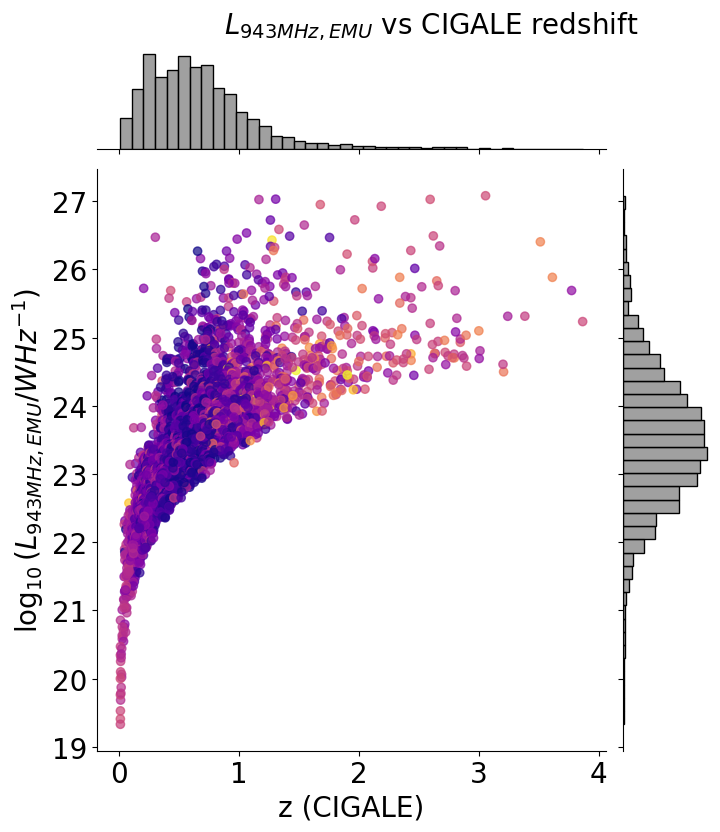

In [46]:
g = sns.JointGrid(
    data=catalog_pd,
    x=catalog_pd['bayes.universe.redshift'],
    y=log_luminosity_943MHz,
    height=8
)

points = g.ax_joint.scatter(
    catalog_pd['bayes.universe.redshift'],
    log_luminosity_943MHz,
    c=catalog_pd['bayes.agn.fracAGN'],
    cmap='plasma',
    alpha=0.7
)

# Add marginal histograms
sns.histplot(
    data=catalog_pd,
    x=catalog_pd['bayes.universe.redshift'],
    bins=40,
    ax=g.ax_marg_x,
    color='grey',
    edgecolor='black'
)
sns.histplot(
    data=catalog_pd,
    y=log_luminosity_943MHz,
    bins=40,
    ax=g.ax_marg_y,
    color='grey',
    edgecolor='black'
)

# Set axis labels and title with larger font
g.set_axis_labels(
    r'z (CIGALE)',
    r'$\log_{10}(L_{943 MHz, EMU}/ W Hz^{-1})$',
    fontsize=20
)
g.ax_joint.tick_params(axis='both', labelsize=20)
g.ax_marg_x.tick_params(labelsize=20)
g.ax_marg_y.tick_params(labelsize=20)

# Title
g.fig.suptitle(r'$L_{943 MHz, EMU}$ vs CIGALE redshift', fontsize=20,  y=1.0)
g.fig.subplots_adjust(top=0.95, right=0.85)  # Shrink plot area to make room for colorbar

plt.show()

## Luminosity from EMU vs Luminosity from CIGALE (colored by AGN fraction)

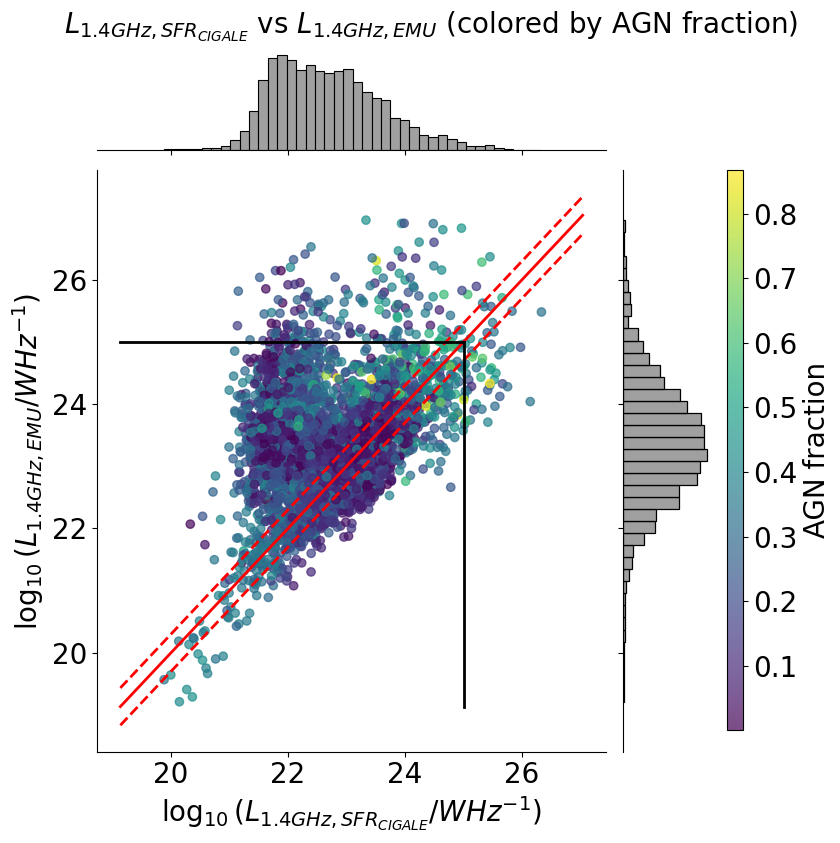

In [47]:
g = sns.JointGrid(
    data=catalog_pd,
    x=log_luminosity_1_4GHz_theor_watt,
    y=log_luminosity_1_4GHz_obs_watt,
    height=8
)

points = g.ax_joint.scatter(
    log_luminosity_1_4GHz_theor_watt,
    log_luminosity_1_4GHz_obs_watt,
    c=catalog_pd['bayes.agn.fracAGN'],
    cmap='viridis',
    alpha=0.7
)

all_luminosity_values = pd.concat([log_luminosity_1_4GHz_theor_watt, log_luminosity_1_4GHz_obs_watt]).dropna()

min_val = all_luminosity_values.min()
max_val = all_luminosity_values.max()

buffer = (max_val - min_val) * 0.01 
common_lim_min = min_val - buffer
common_lim_max = max_val + buffer

# 1:1 and error lines
line_coords = np.linspace(common_lim_min, common_lim_max, 100)
g.ax_joint.plot(line_coords, line_coords, color='red', linestyle='-', linewidth=2, label='1:1 line')
g.ax_joint.plot(line_coords, line_coords+0.3, color='red', linestyle='--', linewidth=2, label='error')
g.ax_joint.plot(line_coords, line_coords-0.3, color='red', linestyle='--', linewidth=2, label='error')

# AGN line in vertical and horizontal directions
g.ax_joint.plot([common_lim_min, 25], [25, 25], color='black', linestyle='-', linewidth=2, label='AGN')
g.ax_joint.plot([25, 25], [common_lim_min, 25], color='black', linestyle='-', linewidth=2, label='AGN')

# AHistograms
sns.histplot(
    data=catalog_pd,
    x=log_luminosity_1_4GHz_theor_watt,
    bins=40,
    ax=g.ax_marg_x,
    color='grey',
    edgecolor='black'
)
sns.histplot(
    data=catalog_pd,
    y=log_luminosity_1_4GHz_obs_watt,
    bins=40,
    ax=g.ax_marg_y,
    color='grey',
    edgecolor='black'
)

g.set_axis_labels(
    r'$\log_{10}(L_{1.4 GHz, SFR_{CIGALE}}/ W Hz^{-1})$',
    r'$\log_{10}(L_{1.4 GHz, EMU}/ W Hz^{-1})$',
    fontsize=20
)
g.ax_joint.tick_params(axis='both', labelsize=20)
g.ax_marg_x.tick_params(labelsize=20)
g.ax_marg_y.tick_params(labelsize=20)


g.fig.suptitle(r'$L_{1.4 GHz, SFR_{CIGALE}}$ vs $L_{1.4 GHz, EMU}$ (colored by AGN fraction)', fontsize=20,  y=1.0)
g.fig.subplots_adjust(top=0.95, right=0.85) 


cbar_ax = g.fig.add_axes([0.87, 0.1, 0.02, 0.7])
cbar = g.fig.colorbar(points, cax=cbar_ax)
cbar.set_label('AGN fraction', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.savefig("/home/polaris/Lab_Astro/radioplot.png", dpi=72)
plt.show()

Add code to count the number of 

Sources to the right of 25Whz of Luminosity derived from CIGALE SFR are too high values for SFR so sould be treated carefully.

## Luminosity from EMU vs Luminosity from CIGALE (colored by CIGALE redshift)

In [48]:
# Calculate the theorical luminosity at 1.4GHz assuming that the SFR given by CIGALE is the same as the SFR at 1.4GHz
#f_IMF = 1.72  # Initial mass function normalization factor, Delhaize et al. 2017
#q_IR = (2.83)*(1+redshift)**(-0.15)  # Delhaize et al. 2017
# log_luminosity_1_4GHz_theor = np.log(catalog_pd['bayes.sfh.sfr'] / (f_IMF * 10 ** q_IR * 10 ** -24))


# Calculate the star formation rate in the radio
# CALIBRATING EXTINCTION-FREE STAR FORMATION RATE DIAGNOSTICS WITH 33 GHz FREE–FREE EMISSION IN NGC 6946, E. J. Murphy 2011
#constant = 6.35e-29
#log_sfr_1_4GHz = np.log(luminosity_1_4GHz_obs * 10000 * constant) 

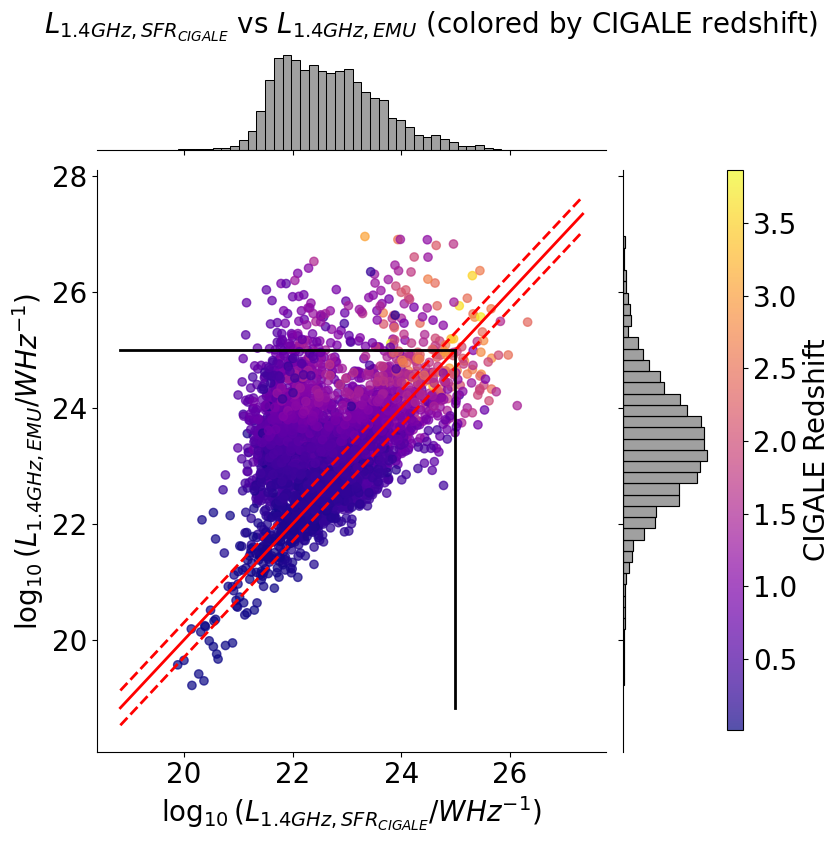

<Figure size 640x480 with 0 Axes>

In [50]:
g = sns.JointGrid(
    data=catalog_pd,
    x=log_luminosity_1_4GHz_theor_watt,
    y=log_luminosity_1_4GHz_obs_watt,
    height=8
)

points = g.ax_joint.scatter(
    log_luminosity_1_4GHz_theor_watt,
    log_luminosity_1_4GHz_obs_watt,
    c=catalog_pd['bayes.universe.redshift'],
    cmap='plasma',
    alpha=0.7
)

all_luminosity_values = pd.concat([log_luminosity_1_4GHz_theor_watt, log_luminosity_1_4GHz_obs_watt]).dropna()

min_val = all_luminosity_values.min()
max_val = all_luminosity_values.max()

# Add a small buffer to the limits for better visual spacing
buffer = (max_val - min_val) * 0.05 # 5% buffer
common_lim_min = min_val - buffer
common_lim_max = max_val + buffer

# 1:1 and error lines
line_coords = np.linspace(common_lim_min, common_lim_max, 100)
g.ax_joint.plot(line_coords, line_coords, color='red', linestyle='-', linewidth=2, label='1:1 line')
g.ax_joint.plot(line_coords, line_coords+0.3, color='red', linestyle='--', linewidth=2, label='error')
g.ax_joint.plot(line_coords, line_coords-0.3, color='red', linestyle='--', linewidth=2, label='error')

# AGN line in vertical and horizontal directions
g.ax_joint.plot([common_lim_min, 25], [25, 25], color='black', linestyle='-', linewidth=2, label='AGN')
g.ax_joint.plot([25, 25], [common_lim_min, 25], color='black', linestyle='-', linewidth=2, label='AGN')

# Add marginal histograms
sns.histplot(
    data=catalog_pd,
    x=log_luminosity_1_4GHz_theor_watt,
    bins=40,
    ax=g.ax_marg_x,
    color='grey',
    edgecolor='black'
)
sns.histplot(
    data=catalog_pd,
    y=log_luminosity_1_4GHz_obs_watt,
    bins=40,
    ax=g.ax_marg_y,
    color='grey',
    edgecolor='black'
)

# Set axis labels and title with larger font
g.set_axis_labels(
    r'$\log_{10}(L_{1.4 GHz, SFR_{CIGALE}}/ W Hz^{-1})$',
    r'$\log_{10}(L_{1.4 GHz, EMU}/ W Hz^{-1})$',
    fontsize=20
)
g.ax_joint.tick_params(axis='both', labelsize=20)
g.ax_marg_x.tick_params(labelsize=20)
g.ax_marg_y.tick_params(labelsize=20)

# Title
g.fig.suptitle(r'$L_{1.4 GHz, SFR_{CIGALE}}$ vs $L_{1.4 GHz, EMU}$ (colored by CIGALE redshift)', fontsize=20,  y=1.0)
g.fig.subplots_adjust(top=0.95, right=0.85)  # Shrink plot area to make room for colorbar

# Add external colorbar with larger label and ticks
cbar_ax = g.fig.add_axes([0.87, 0.1, 0.02, 0.7])
cbar = g.fig.colorbar(points, cax=cbar_ax)
cbar.set_label('CIGALE Redshift', fontsize=20)
cbar.ax.tick_params(labelsize=20)

plt.show()
plt.savefig("/home/polaris/Lab_Astro/radioplot.png", dpi=72, bbox_inches='tight')